<a href="https://colab.research.google.com/github/xghan99/dsa4212-assignments/blob/main/RecommendingWithAverages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and Setting Up GDrive

In [ ]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import time

from sklearn.model_selection import train_test_split
from scipy import sparse

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Change directory here!
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/DSA4212/DSA4212_Assignment2


# Reading Data

In [ ]:
train_all = pd.read_csv('assignment_2_ratings_train.csv')
train_all.shape

(4436068, 3)

In [ ]:
#Overview of the Headings and the Dataset
train_all.head()

,user_id,anime_id,rating
0,20170,10794,6
1,24592,21995,5
2,18358,7054,10
3,59267,488,7
4,69313,30544,4


In [ ]:
#Shuffle the Dataset
train_all_shuffled = train_all.sample(frac = 1)
train_all_shuffled.head()

,user_id,anime_id,rating
918808,936,12549,9
4066718,31374,2476,4
430241,71647,2476,7
1980180,64256,12355,8
2472094,33846,585,7


In [ ]:
#Perform 80-20 Train Validation Split
train, valid = train_test_split(train_all_shuffled, test_size=0.2)

# Random Uniform


We generate a random integer from 1 to 10 as our prediction for every user and anime pair in the validation set.

In [ ]:
pred_size = valid.shape[0]

In [ ]:
#generating random rating for all ratings 
random_predict = np.random.randint(1, 10, pred_size)

print("validation MSE(random uniform): ", jnp.mean((valid['rating'].to_numpy() - random_predict)**2))

validation MSE(random uniform):  17.029726


# Random From Training Distribution

This time, we will still generate a random integerm from 1 to 10, but use the distribution of the training dataset 

In [ ]:
random_predict_dist = np.random.choice(train['rating'], size = pred_size)

In [ ]:
print("validation MSE(random dist): ", jnp.mean((valid['rating'].to_numpy() - random_predict_dist)**2))

validation MSE(random dist):  4.9319005


# Computing Averages by User and Anime



In [ ]:
#Obtaining the Average Rating by Anime
train_avg_by_anime = train.groupby('anime_id')[['rating']].mean()
train_avg_by_anime.head()

,rating
anime_id,
1,8.876884
5,8.423342
6,8.427624
7,7.482671
8,7.175258


In [ ]:
#Obtaining the Average Rating by User
train_avg_by_user = train.groupby('user_id')[['rating']].mean()
train_avg_by_user.head()

,rating
user_id,
1,10.000000
3,7.382979
5,4.466135
7,7.237569
8,7.400000


In [ ]:
#Converting Training Dataset to numpy array
train_np = jnp.array(train)
train_np

Array([[ 2422,    49,     6],
       [64265,  7769,     8],
       [19894,  5958,     7],
       ...,
       [52046,  6114,     7],
       [31866,  1157,     7],
       [71040, 30015,     8]], dtype=int32)

In [ ]:
train_np.shape

(3548854, 3)

In [ ]:
#Converting Validation Dataset to numpy array
val_np = jnp.array(valid)
val_np

Array([[ 5785,  2418,     9],
       [24584,  2890,     9],
       [59056,    52,     7],
       ...,
       [69003,   482,     9],
       [45535,  3352,    10],
       [ 7053,    60,     9]], dtype=int32)

# Weighted Average of User Mean and Anime Mean

The following section explores the following methods for predicting ratings:


1.   Weighted Average of User Mean and Anime Mean
2.   User Mean
3.   Anime Mean




## Gradient Descent to find optimal weights

In [ ]:
#Defining a MSE loss function to find optimal weights C for the weighted average
def loss(c,x):
  user_ids, anime_ids, ratings = x[:,0], x[:,1], x[:,2]

  #locates the mean user ratings for each user_id in user_ids
  avg_user = jnp.array(train_avg_by_user.loc[user_ids,].rating)

  #locates the mean anime ratings for each anime_id in anime_ids
  avg_anime = jnp.array(train_avg_by_anime.loc[anime_ids,].rating)

  #compute weighted average
  preds = c*avg_user + (1-c)*avg_anime
  
  #Return MSE between prediction and actual ratings
  return jnp.mean((preds-ratings)**2)

loss_value_and_grad = jax.value_and_grad(loss)

In [ ]:
#Global Average Rating
global_avg_rating = jnp.mean(train_np[:,2])

In [ ]:
# Generate Set of unique User IDs and Anime IDs
user_set = set(train_avg_by_user.index)
anime_set = set(train_avg_by_anime.index)

In [ ]:
# Splits a validation set into 4 categories, in_both denotes entries where both user and anime exists in the training dataset, in_user denotes that only user exists, 
# in_anime denotes that only anime exists, and in_none denotes that anime and user both do not exist in the trainig dataset
# Returns the 4 lists which contain indices denoting which row belongs to which category
def split_category(x, user_set, anime_set):
  user_id, anime_id, rating = np.array(x[:,0]), np.array(x[:,1]), np.array(x[:,2])
  in_both = np.array([i for i in range(len(x)) if user_id[i] in user_set and anime_id[i] in anime_set])
  in_user = np.array([i for i in range(len(x)) if user_id[i] in user_set and anime_id[i] not in anime_set])
  in_anime = np.array([i for i in range(len(x)) if user_id[i] not in user_set and anime_id[i] in anime_set])
  in_none = np.array([i for i in range(len(x)) if user_id[i] not in user_set and anime_id[i] not in anime_set])
  return in_both, in_user, in_anime, in_none

In [ ]:
in_both, in_user, in_anime, in_none = split_category(val_np, user_set, anime_set)

In [ ]:
# sanity check to ensure no over/undercounting
print(len(in_both) + len(in_user) + len(in_anime) + len(in_none) == len(val_np))

True


In [ ]:
#Verify that in_none is empty
print(len(in_none))

0


In [ ]:
#Function for generating predictions on validation set using weight c
def val_pred(x,c):
  user_id, anime_id, rating = np.array(x[:,0]), np.array(x[:,1]), np.array(x[:,2])
  squared_error = 0
  #Pred in Both
  pred_both = jnp.array(train_avg_by_user.loc[user_id[in_both],].rating)*c + jnp.array(train_avg_by_anime.loc[anime_id[in_both],].rating)*(1-c)
  squared_error += jnp.sum((pred_both-np.array(rating[in_both]))**2)
  
  #Missing Values are replaced with the global average
  #Pred in User only
  pred_user = jnp.array(train_avg_by_user.loc[user_id[in_user],].rating)*c + global_avg_rating*(1-c)
  squared_error += jnp.sum((pred_user-np.array(rating[in_user]))**2)
  #Pred in Anime only
  pred_anime = global_avg_rating*c + jnp.array(train_avg_by_anime.loc[anime_id[in_anime],].rating)*(1-c)
  squared_error += jnp.sum((pred_anime-np.array(rating[in_anime]))**2)
  return squared_error/len(x)

In [ ]:
#Initial c and hyperparameters
c = 0.5
niter = 40
eta = 0.1
#Tracking training loss, validation loss, and value of c
tr_loss_traj = []
val_loss_traj = []
c_traj = []

#Gradient Descent
for i in range(niter):
  v,g = loss_value_and_grad(c, train_np)
  val_loss = val_pred(val_np, c)
  c_traj.append(c)
  tr_loss_traj.append(v)
  val_loss_traj.append(val_loss)
  c = c-g*eta


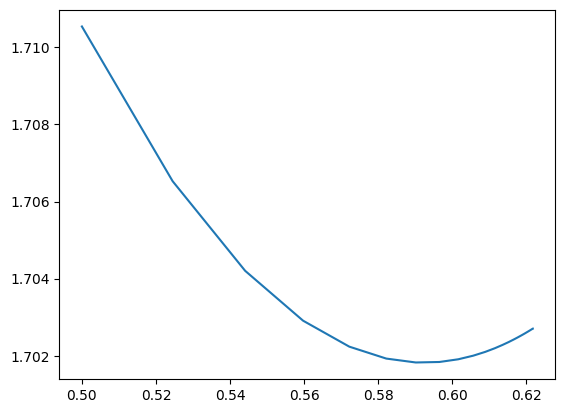

In [ ]:
plt.plot(c_traj,val_loss_traj)

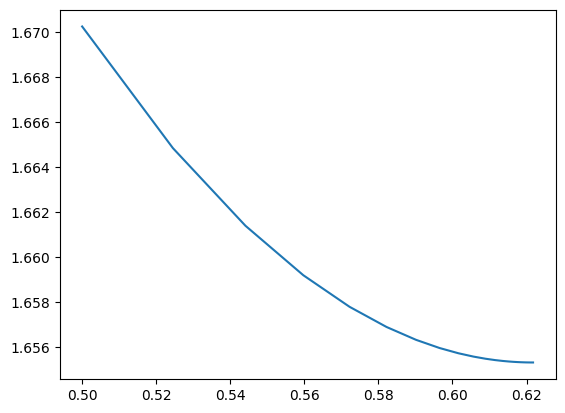

In [ ]:
plt.plot(c_traj, tr_loss_traj)

## Evaluation and Comparison

In [ ]:
#Finding Optimal C and lowest validation loss
c_optim = c_traj[np.argmin(val_loss_traj)]
val_loss_optim = val_loss_traj[np.argmin(val_loss_traj)]
print(c_optim,val_loss_optim)

0.59016824 1.7018244


In [ ]:
# Validation MSE for using User Average Only (c = 1)
val_pred(val_np,1)

Array(1.8716961, dtype=float32)

In [ ]:
# Validation MSE for using Anime Average Only (c = 0)
val_pred(val_np,0)

Array(2.0605745, dtype=float32)

In [ ]:
# Validaiton MSE for using equally weighted User and Anime Average (c = 0.5)
val_pred(val_np,0.5)

Array(1.710543, dtype=float32)

In [ ]:
# Validation MSE for by always predicting Global Average
jnp.mean((val_np[:,2] - global_avg_rating)**2)

Array(2.471419, dtype=float32)

## Conclusion

Evidently, taking the average of the User and Anime Average provides better predictive performance relative to using each one in isolation. Furthermore, an optimised weighted average manages to have a better Validation MSE over a simple weighted average.